# 2-D Ising Model experiment
*(after Mehta et al.)*

The states of the 2D Ising model according to their phase.

The Hamiltonian for the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2-D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions so that every site has 4 nearest neighbors, even at the boundaries.

Onsager proved that this model undergoes a phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.

For this hands-on example, we'll train a Deep Neural Network to predict whether a certain 2-D spin state configuration will result in a disordered phase (label "0") or ordered phase (label "1").

In [1]:
import pickle
import numpy as np
from urllib.request import urlopen

def load_data():

    url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

    # The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
    data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
    # The labels are obtained from the following file:
    label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

    data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
    data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
    data=data.astype('int')
    data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

    #labels (convention is 1 for ordered states and 0 for disordered states)
    labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

    print("Finished loading data")
    return data, labels

data, labels = load_data()

Finished loading data


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Define a custom Dataset for the Ising model data
class IsingDataset(Dataset):
    def __init__(self, features, labels):
        # Convert numpy arrays to torch tensors
        self.features = torch.tensor(features, dtype=torch.float32)
        # Labels should be float for BCEWithLogitsLoss and have a shape [N, 1]
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Split the data into training and testing sets
# Using test_size=0.2 as a common practice, adjust if needed
X_train_ising, X_test_ising, y_train_ising, y_test_ising = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Ising training features shape: {X_train_ising.shape}, Ising training labels shape: {y_train_ising.shape}")
print(f"Ising testing features shape: {X_test_ising.shape}, Ising testing labels shape: {y_test_ising.shape}")

# Create instances of the custom Dataset
ising_train_dataset = IsingDataset(X_train_ising, y_train_ising)
ising_test_dataset = IsingDataset(X_test_ising, y_test_ising)

# Create DataLoaders
batch_size = 128 # You can adjust this batch size
ising_training_dataloader = DataLoader(ising_train_dataset, batch_size=batch_size, shuffle=True)
ising_testing_dataloader = DataLoader(ising_test_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle test data

print(f"Number of Ising training batches: {len(ising_training_dataloader)}")
print(f"Number of Ising testing batches: {len(ising_testing_dataloader)}")

Ising training features shape: (128000, 1600), Ising training labels shape: (128000,)
Ising testing features shape: (32000, 1600), Ising testing labels shape: (32000,)
Number of Ising training batches: 1000
Number of Ising testing batches: 250


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# define DNN model
model = nn.Sequential(
    nn.Linear(1600, 160),
    nn.ELU(),
    nn.Linear(160, 12),
    nn.ELU(),
    nn.Linear(12, 1),
    nn.Sigmoid()
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 1cycle implement in Torch as OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,                      # Peak learning rate
    epochs=100,                      # Total epochs
    steps_per_epoch=len(ising_training_dataloader),  # Batches per epoch
    pct_start=0.3,                   # 30% warmup, 70% annealing
    anneal_strategy='cos',           # Cosine annealing
    div_factor=25.0,                 # Initial LR = max_lr/25
    final_div_factor=1e4             # Final LR = max_lr/10000
)

# training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(ising_training_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # CRITICAL for 1cycle: step scheduler after each batch, not each epoch!
        scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.5591
Epoch [2/100], Loss: 0.4945
Epoch [3/100], Loss: 0.5122
Epoch [4/100], Loss: 0.4552
Epoch [5/100], Loss: 0.5083
Epoch [6/100], Loss: 0.5034
Epoch [7/100], Loss: 0.5004
Epoch [8/100], Loss: 0.4797
Epoch [9/100], Loss: 0.4655
Epoch [10/100], Loss: 0.5032
Epoch [11/100], Loss: 0.4528
Epoch [12/100], Loss: 0.4735
Epoch [13/100], Loss: 0.4971
Epoch [14/100], Loss: 0.4973
Epoch [15/100], Loss: 0.4706
Epoch [16/100], Loss: 0.4587
Epoch [17/100], Loss: 0.4854
Epoch [18/100], Loss: 0.4663
Epoch [19/100], Loss: 0.4617
Epoch [20/100], Loss: 0.4617
Epoch [21/100], Loss: 0.4706
Epoch [22/100], Loss: 0.4676
Epoch [23/100], Loss: 0.4943
Epoch [24/100], Loss: 0.4598
Epoch [25/100], Loss: 0.4765
Epoch [26/100], Loss: 0.4646
Epoch [27/100], Loss: 0.4646
Epoch [28/100], Loss: 0.5002
Epoch [29/100], Loss: 0.5032
Epoch [30/100], Loss: 0.4854
Epoch [31/100], Loss: 0.4765
Epoch [32/100], Loss: 0.4765
Epoch [33/100], Loss: 0.4498
Epoch [34/100], Loss: 0.4735
Epoch [35/100], Loss: 0

KeyboardInterrupt: 

Using the Colab GPU tricks (see below), we can make the training go much faster.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# define DNN model
model = nn.Sequential(
    nn.Linear(1600, 160),
    nn.ELU(),
    nn.Linear(160, 12),
    nn.ELU(),
    nn.Linear(12, 1),
    nn.Sigmoid()
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 1cycle implement in Torch as OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,                      # Peak learning rate
    epochs=20,                      # Total epochs
    steps_per_epoch=len(ising_training_dataloader),  # Batches per epoch
    pct_start=0.3,                   # 30% warmup, 70% annealing
    anneal_strategy='cos',           # Cosine annealing
    div_factor=25.0,                 # Initial LR = max_lr/25
    final_div_factor=1e4             # Final LR = max_lr/10000
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Moves all model parameters to GPU

# training loop
num_epochs = 20
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(ising_training_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # CRITICAL for 1cycle: step scheduler after each batch, not each epoch!
        scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.4863
Epoch [2/20], Loss: 0.4973
Epoch [3/20], Loss: 0.4754
Epoch [4/20], Loss: 0.4563
Epoch [5/20], Loss: 0.4852
Epoch [6/20], Loss: 0.4973
Epoch [7/20], Loss: 0.4764
Epoch [8/20], Loss: 0.5005
Epoch [9/20], Loss: 0.4646
Epoch [10/20], Loss: 0.4722
Epoch [11/20], Loss: 0.4706
Epoch [12/20], Loss: 0.4468
Epoch [13/20], Loss: 0.4706
Epoch [14/20], Loss: 0.4765
Epoch [15/20], Loss: 0.4706
Epoch [16/20], Loss: 0.4854
Epoch [17/20], Loss: 0.4913
Epoch [18/20], Loss: 0.5062
Epoch [19/20], Loss: 0.5091
Epoch [20/20], Loss: 0.5032


Accuracy on training data: 0.9928
Thresholds (first 10): [       inf 1.         0.9999999  0.99999976 0.99999964 0.9999995
 0.9999994  0.9999993  0.99999917 0.99999857]


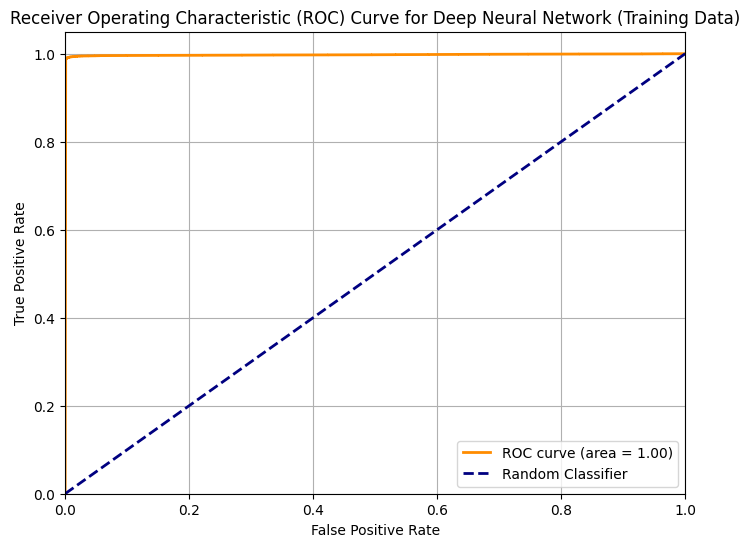

In [8]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure the model is on the correct device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for data, target in ising_testing_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_predictions.extend(output.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)

# For binary classification with Sigmoid, output is already probability, but ensure shape is correct
# y_pred_proba will be (N, 1), we need (N,) for roc_curve
y_pred_proba = y_pred_proba.flatten()
y_true = y_true.flatten()

# Convert probabilities to binary predictions for accuracy calculation (e.g., threshold at 0.5)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy on testing data: {accuracy:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print("Thresholds (first 10):", thresholds[:10]) # Print first 10 thresholds, not all

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Deep Neural Network (Training Data)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

It looks like this Deep Neural Network is practically perfect at learning whether the 2-D Ising spin configuration corresponds to an ordered or disordered state.

It would be interesting to see how simple the DNN can be, while still maintaining its performance.

# Deeeep Neural Network for SUSY event classification

The SUSY ML dataset at UCI is sufficiently large and complex that a deep neural network is worth the effort. Smaller datasets like iris don't provide enough data variance to train the large number of model parameters in the DNN.

We will use the same data loading techniques as for the multi-layer perceptron.

In [9]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from google.colab import drive
drive.mount('/content/drive')

class CSVDataset(Dataset):
    def __init__(self, csv_file, max_samples=None):
        self.data = pd.read_csv(csv_file)
        if max_samples:
            self.data = self.data.iloc[:max_samples]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = torch.tensor(row.iloc[1:].values, dtype=torch.float32)
        label = torch.tensor(row.iloc[0], dtype=torch.float32)
        return features, label

# Use it with DataLoader
#dataset = CSVDataset('https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz', 1000)
dataset = CSVDataset('/content/drive/My Drive/Colab Notebooks/SUSY.csv.gz', 10000)

# Define split ratios (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}\n")

# DataLoaders handle batching, shuffling, and parallel loading
training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testing_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Mounted at /content/drive
Training samples: 8000
Testing samples: 2000



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# define DNN model
model = nn.Sequential(
    nn.Linear(18, 20),
    nn.ELU(),
    nn.Linear(20, 20),
    nn.ELU(),
    nn.Linear(20, 20),
    nn.ELU(),
    nn.Linear(20, 1),
    nn.Sigmoid()
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 1cycle implement in Torch as OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.1,                      # Peak learning rate
    epochs=50,                      # Total epochs
    steps_per_epoch=len(training_dataloader),  # Batches per epoch
    pct_start=0.3,                   # 30% warmup, 70% annealing
    anneal_strategy='cos',           # Cosine annealing
    div_factor=25.0,                 # Initial LR = max_lr/25
    final_div_factor=1e4             # Final LR = max_lr/10000
)

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(training_dataloader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1)) # Added .unsqueeze(1) to match target shape to model output
        loss.backward()
        optimizer.step()

        # CRITICAL for 1cycle: step scheduler after each batch, not each epoch!
        scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.6391
Epoch [2/50], Loss: 0.6155
Epoch [3/50], Loss: 0.6879
Epoch [4/50], Loss: 0.5834
Epoch [5/50], Loss: 0.6092
Epoch [6/50], Loss: 0.6575
Epoch [7/50], Loss: 0.6931
Epoch [8/50], Loss: 0.6736
Epoch [9/50], Loss: 0.6931
Epoch [10/50], Loss: 0.6931
Epoch [11/50], Loss: 0.6931
Epoch [12/50], Loss: 0.6931
Epoch [13/50], Loss: 0.6931
Epoch [14/50], Loss: 0.6931
Epoch [15/50], Loss: 0.6931
Epoch [16/50], Loss: 0.6931
Epoch [17/50], Loss: 0.6931
Epoch [18/50], Loss: 0.6931
Epoch [19/50], Loss: 0.6931
Epoch [20/50], Loss: 0.6931
Epoch [21/50], Loss: 0.6931
Epoch [22/50], Loss: 0.6931
Epoch [23/50], Loss: 0.6931
Epoch [24/50], Loss: 0.6931
Epoch [25/50], Loss: 0.6931
Epoch [26/50], Loss: 0.6931
Epoch [27/50], Loss: 0.6931
Epoch [28/50], Loss: 0.6931
Epoch [29/50], Loss: 0.6931
Epoch [30/50], Loss: 0.6931
Epoch [31/50], Loss: 0.6931
Epoch [32/50], Loss: 0.6931
Epoch [33/50], Loss: 0.6931
Epoch [34/50], Loss: 0.6931
Epoch [35/50], Loss: 0.6931
Epoch [36/50], Loss: 0.6931
E

Accuracy on testing data: 0.5415
Thresholds (first 10): [inf  0.]


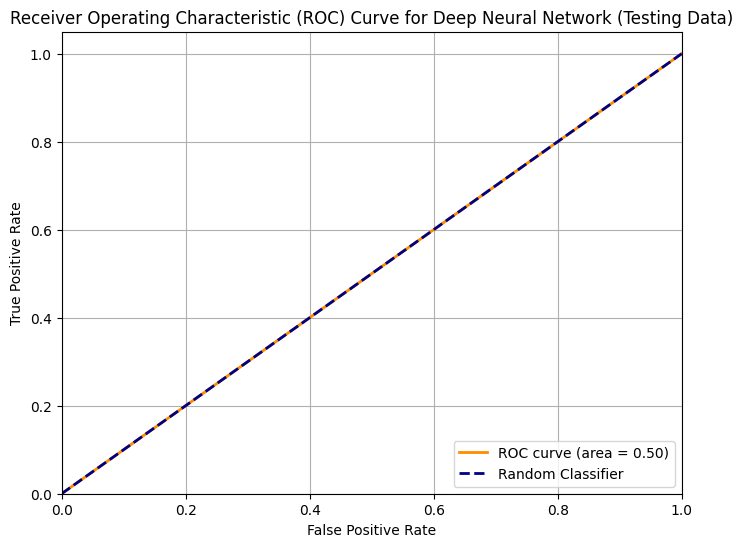

In [11]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure the model is on the correct device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for data, target in testing_dataloader: # Use ising_testing_dataloader for evaluation
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_predictions.extend(output.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)

# For binary classification with Sigmoid, output is already probability, but ensure shape is correct
# y_pred_proba will be (N, 1), we need (N,) for roc_curve
y_pred_proba = y_pred_proba.flatten()
y_true = y_true.flatten()

# Convert probabilities to binary predictions for accuracy calculation (e.g., threshold at 0.5)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy on testing data: {accuracy:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print("Thresholds (first 10):", thresholds[:10]) # Print first 10 thresholds, not all

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Deep Neural Network (Testing Data)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

This result looks very poor, no better than a random classifier (coin flip). Before we try to solve the problem, let's look at how to speed up the training.

# Using GPUs in Colab

We now turn to an important enabler of Deep Neural Networks -- the Graphical Processing Unit (GPU), which is built for massively parallel arithmetic operations. For Machine Learning, the killer app is matrix multiplication (MatMul), which is the backbone of neural network training and inference.

## Enabling GPUs in Colab

To switch to a GPU-enabled runtime instance in Colab, go to the **Runtime** menu and select **Change runtime type**.
The **T4 GPU** instance is always free for Colab Pro users; more advanced GPUs may require payment.
We expect the T4 GPUs will be sufficient for all of our work in this course.

*Change the runtime type to T4 GPU for the following hands-on work now.*

Check to see if the GPU is enabled by using `torch.cuda.is_available()`. (Cuda is NVIDIA's custom software for processing on GPUs. Torch will use Cuda libraries if you ask it to do so.)

In [12]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.83 GB


The key step for GPU-enabled training is loading the model and data into the local GPU memory.

We update the code for the SUSY classification here, with the correct calls to load model and data into the GPUs.
Try benchmarking this code with a CPU runtime type vs. GPU runtime type.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# define DNN model
model = nn.Sequential(
    nn.Linear(18, 20),
    nn.ELU(),
    nn.Linear(20, 20),
    nn.ELU(),
    nn.Linear(20, 20),
    nn.ELU(),
    nn.Linear(20, 1),
    nn.Sigmoid()
)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 1cycle implement in Torch as OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.01,                      # Peak learning rate
    epochs=50,                      # Total epochs
    steps_per_epoch=len(training_dataloader),  # Batches per epoch
    pct_start=0.3,                   # 30% warmup, 70% annealing
    anneal_strategy='cos',           # Cosine annealing
    div_factor=25.0,                 # Initial LR = max_lr/25
    final_div_factor=1e4             # Final LR = max_lr/10000
)

model = model.to(device)  # Moves all model parameters to GPU

num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(training_dataloader):
        # Move batch to GPU
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # CRITICAL for 1cycle: step scheduler after each batch, not each epoch!
        scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.6655
Epoch [2/50], Loss: 0.6334
Epoch [3/50], Loss: 0.6477
Epoch [4/50], Loss: 0.6019
Epoch [5/50], Loss: 0.5548
Epoch [6/50], Loss: 0.5510
Epoch [7/50], Loss: 0.6001
Epoch [8/50], Loss: 0.6052
Epoch [9/50], Loss: 0.6041
Epoch [10/50], Loss: 0.5963
Epoch [11/50], Loss: 0.6279
Epoch [12/50], Loss: 0.6185
Epoch [13/50], Loss: 0.5287
Epoch [14/50], Loss: 0.6427
Epoch [15/50], Loss: 0.5625
Epoch [16/50], Loss: 0.6527
Epoch [17/50], Loss: 0.5354
Epoch [18/50], Loss: 0.6455
Epoch [19/50], Loss: 0.5651
Epoch [20/50], Loss: 0.6235
Epoch [21/50], Loss: 0.6170
Epoch [22/50], Loss: 0.6501
Epoch [23/50], Loss: 0.6574
Epoch [24/50], Loss: 0.6136
Epoch [25/50], Loss: 0.5879
Epoch [26/50], Loss: 0.6337
Epoch [27/50], Loss: 0.6288
Epoch [28/50], Loss: 0.6017
Epoch [29/50], Loss: 0.5110
Epoch [30/50], Loss: 0.5589
Epoch [31/50], Loss: 0.5538
Epoch [32/50], Loss: 0.6302
Epoch [33/50], Loss: 0.5801
Epoch [34/50], Loss: 0.6241
Epoch [35/50], Loss: 0.6076
Epoch [36/50], Loss: 0.6825
E

You should notice that the training goes much faster, for the same number of epochs.

But the proof is in the testing accuracy.

Accuracy on testing data: 0.8050
Thresholds (first 10): [       inf 1.         0.9999999  0.99999976 0.99999964 0.9999995
 0.9999994  0.9999993  0.99999917 0.99999905]


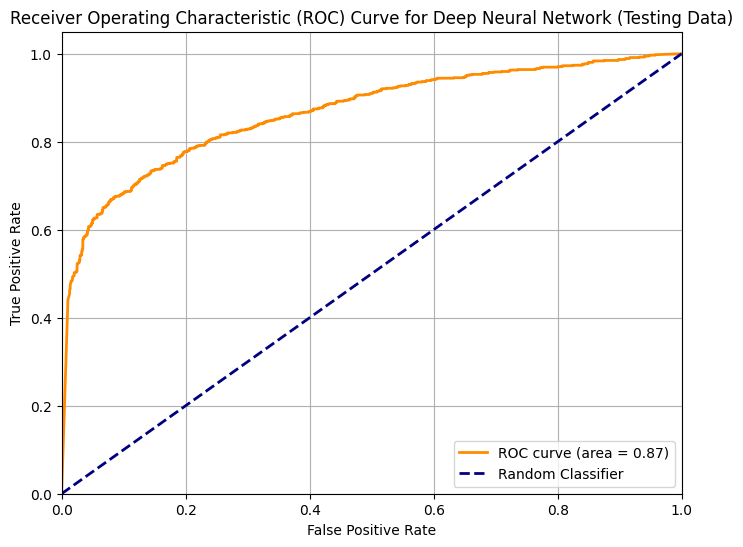

In [14]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure the model is on the correct device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()

all_labels = []
all_predictions = []

# Disable gradient calculations for inference
with torch.no_grad():
    for data, target in testing_dataloader: # Use ising_testing_dataloader for evaluation
        data, target = data.to(device), target.to(device)
        output = model(data)
        all_predictions.extend(output.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(all_labels)
y_pred_proba = np.array(all_predictions)

# For binary classification with Sigmoid, output is already probability, but ensure shape is correct
# y_pred_proba will be (N, 1), we need (N,) for roc_curve
y_pred_proba = y_pred_proba.flatten()
y_true = y_true.flatten()

# Convert probabilities to binary predictions for accuracy calculation (e.g., threshold at 0.5)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred_binary)
print(f"Accuracy on testing data: {accuracy:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

print("Thresholds (first 10):", thresholds[:10]) # Print first 10 thresholds, not all

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Deep Neural Network (Testing Data)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Somehow this is much better than the previous result, using the same DNN model!

We can conclude that the learning rate and the scheduler algorithm make a big difference in the DNN training and accuracy.

# Local GPU training

You can even train and use DNNs on your laptop, if it has a GPU.
the steps will be different for Windows, Linux, and Macs.
The new M-series Macs have powerful GPUs built in, but you should ask for `mps` instead of `cuda`.

```
device = torch.device('mps:0' if torch.mps.is_available() else 'cpu')
print(f"On Mac, using: {device}")
```